# EuroSat Image Classification using Vision ConvNeXt

Hector Becerra  
Juan Terven  
2023

The **ConvNeXt** constructed entirely from standard ConvNet modules, compete favorably with Transformers in terms of accuracy and scalability, achieving 87.8% ImageNet top-1 accuracy and outperforming Swin Transformers on COCO detection and ADE20K segmentation, while maintaining the simplicity and efficiency of standard ConvNets.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import convnext_base,ConvNeXt_Base_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ConvNeXt_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = ConvNeXt_Base_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 128  # The batch size for training data.
val_batch = 32     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

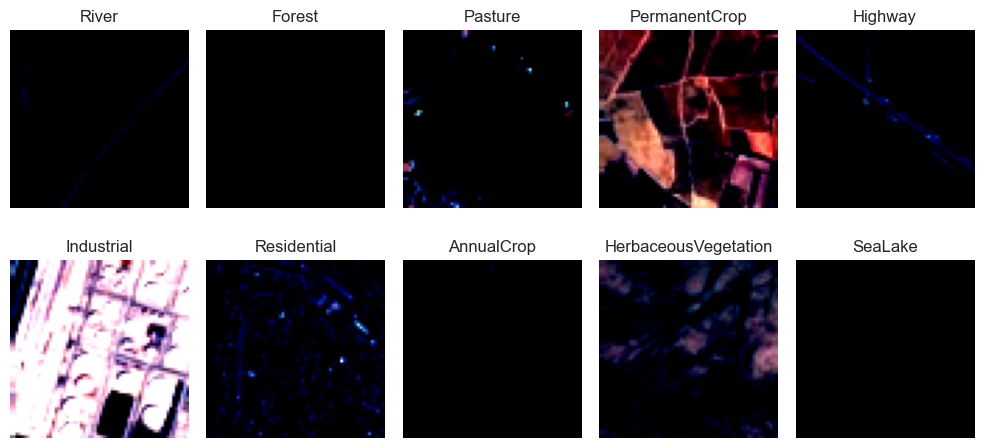

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 148
Validation set batches: 169
Test set examples: 2700


## Labels distribution

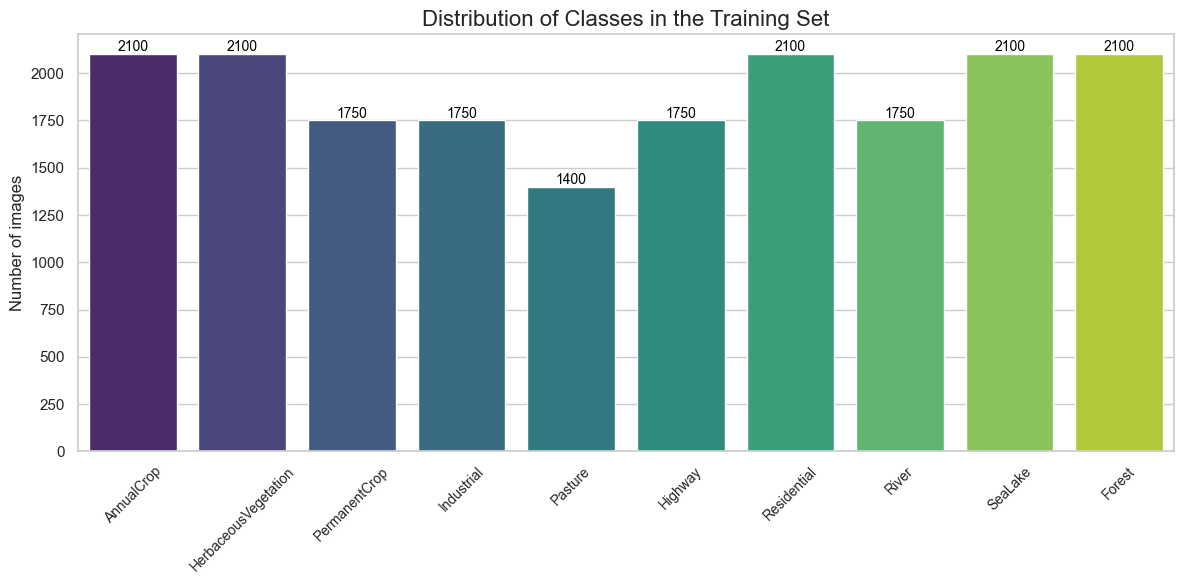

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = convnext_base()

# Replace the model head with the number of classes
num_classes = 10
model.classifier[2] = nn.Linear(1024, num_classes) 
model.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

# Training model from Scratch

In [18]:
project_name = "EuroSAT"
model_name = "ConvNeXt"
models_path = "datasets/Projects/remote_sensing/eurosat_classification/models/"

In [15]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ConvNeXt from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 model_name=model_name,
                                 lr=lr, patience=patience,
                                 device=DEVICE,
                                 model_save_path=models_path)

Starting training with early stopping patience of 10
Each epoch has 148 steps.

Epoch: 1...
Step: 21/148 Loss: 2.1768479466438295
Step: 41/148 Loss: 1.9377906441688537
Step: 61/148 Loss: 1.9038191258907318
Step: 81/148 Loss: 1.7657388627529145
Step: 101/148 Loss: 1.7550922751426696
Step: 121/148 Loss: 1.7051830470561982
Step: 141/148 Loss: 1.6272387146949767
Validation Loss: 1.6497 Accuracy: 0.3967
Best model saved.
Epoch duration: 146.17s

Epoch: 2...
Step: 21/148 Loss: 1.6006903886795043
Step: 41/148 Loss: 1.399729961156845
Step: 61/148 Loss: 1.288752830028534
Step: 81/148 Loss: 1.3118280291557312
Step: 101/148 Loss: 1.2463641226291657
Step: 121/148 Loss: 1.222733384370804
Step: 141/148 Loss: 1.1633521676063538
Validation Loss: 1.1883 Accuracy: 0.5706
Best model saved.
Epoch duration: 54.19s

Epoch: 3...
Step: 21/148 Loss: 1.15538532435894
Step: 41/148 Loss: 1.1012582272291183
Step: 61/148 Loss: 1.0128968596458434
Step: 81/148 Loss: 1.0438897728919982
Step: 101/148 Loss: 1.0829089283

Step: 61/148 Loss: 0.0005192910553887487
Step: 81/148 Loss: 0.0005583003978244961
Step: 101/148 Loss: 0.0005427727024652995
Step: 121/148 Loss: 0.0005372867686673999
Step: 141/148 Loss: 0.0005043767741881311
Validation Loss: 1.1593 Accuracy: 0.7844
Best model saved.
Epoch duration: 55.94s

Epoch: 24...
Step: 21/148 Loss: 0.00048205854109255596
Step: 41/148 Loss: 0.0004560786095680669
Step: 61/148 Loss: 0.0004628971306374297
Step: 81/148 Loss: 0.000468145142076537
Step: 101/148 Loss: 0.0004862164831138216
Step: 121/148 Loss: 0.00046195834001991896
Step: 141/148 Loss: 0.0004603046501870267
Validation Loss: 1.1745 Accuracy: 0.7839
Epoch duration: 54.02s

Epoch: 25...
Step: 21/148 Loss: 0.0004484713601414114
Step: 41/148 Loss: 0.00039184450724860653
Step: 61/148 Loss: 0.00038883612724021076
Step: 81/148 Loss: 0.0004091313036042266
Step: 101/148 Loss: 0.00041231300128856673
Step: 121/148 Loss: 0.000375499164510984
Step: 141/148 Loss: 0.00040149530104827136
Validation Loss: 1.1803 Accuracy: 

In [16]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

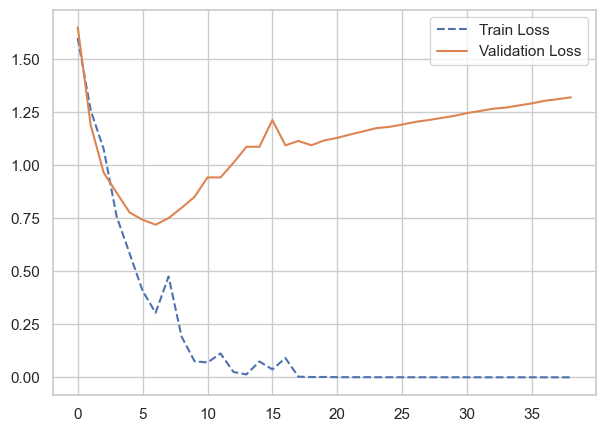

In [17]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

## Load best trained model

In [ ]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}_best_model.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

In [19]:
# Call this function before evaluating your model to remove any wandb hook if needed
#remove_wandb_hooks(model)

In [21]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.816     0.843     0.830       300
              Forest      0.926     0.963     0.944       300
HerbaceousVegetation      0.705     0.660     0.682       300
             Highway      0.613     0.488     0.543       250
          Industrial      0.812     0.864     0.837       250
             Pasture      0.787     0.850     0.817       200
       PermanentCrop      0.625     0.632     0.628       250
         Residential      0.768     0.837     0.801       300
               River      0.693     0.676     0.684       250
             SeaLake      0.990     0.963     0.976       300

            accuracy                          0.783      2700
           macro avg      0.773     0.778     0.774      2700
        weighted avg      0.779     0.783     0.780      2700



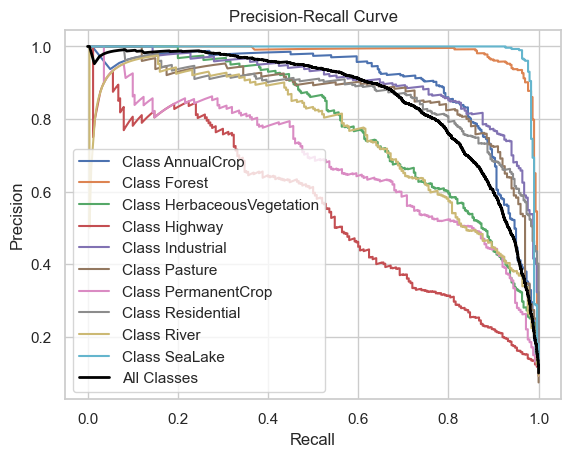

In [21]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [22]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇█▇█▇███▇▇███████████████████████
val_loss,█▅▃▂▁▁▁▁▂▂▃▃▃▄▄▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆
epoch,38
step,5764
train_loss,9e-05
val_accuracy,0.78574
val_loss,1.31953


## Load the precision/recall curve and plot it

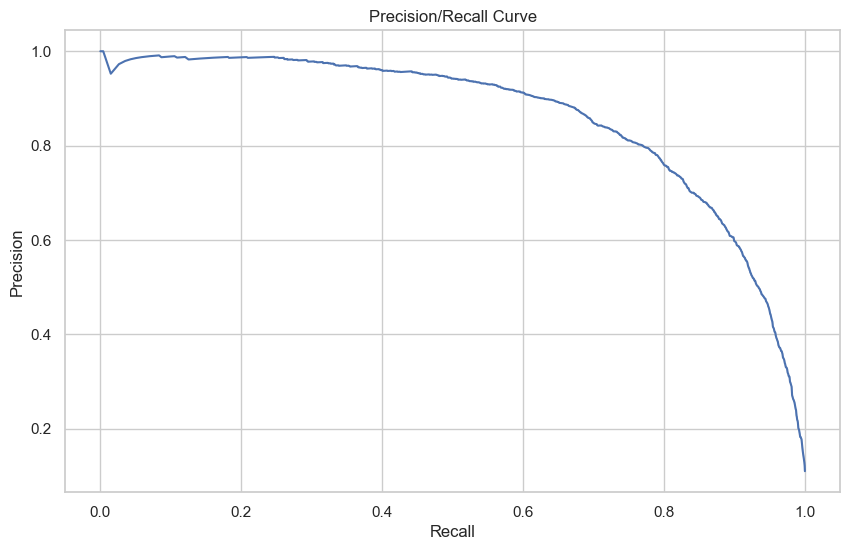

In [23]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [22]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


429

# Now train the model with pre-trained weights

In [23]:
# Use pretrained model
model2 = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier[2] = nn.Linear(1024, num_classes) 
model2.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

## Train with pre-trained weights

In [24]:
model_name = "ConvNeXt-Pretrained"

In [26]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ConvNeXt pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 model_name=model_name,
                                 lr=lr, patience=patience,
                                 device=DEVICE,
                                 model_save_path=models_path
                                )

Starting training with early stopping patience of 10
Each epoch has 148 steps.

Epoch: 1...
Step: 21/148 Loss: 1.4286532342433929
Step: 41/148 Loss: 0.32248934283852576
Step: 61/148 Loss: 0.15917846672236918
Step: 81/148 Loss: 0.11138019356876612
Step: 101/148 Loss: 0.1181506397202611
Step: 121/148 Loss: 0.10366913434118033
Step: 141/148 Loss: 0.09516088645905256
Validation Loss: 0.0759 Accuracy: 0.9774
Best model saved.
Epoch duration: 55.48s

Epoch: 2...
Step: 21/148 Loss: 0.04388359845615923
Step: 41/148 Loss: 0.04789444752968848
Step: 61/148 Loss: 0.035549700097180906
Step: 81/148 Loss: 0.04240307507570833
Step: 101/148 Loss: 0.035422901855781674
Step: 121/148 Loss: 0.041341264522634445
Step: 141/148 Loss: 0.025152276223525404
Validation Loss: 0.0709 Accuracy: 0.9794
Best model saved.
Epoch duration: 55.63s

Epoch: 3...
Step: 21/148 Loss: 0.013414452667348087
Step: 41/148 Loss: 0.009396167390514165
Step: 61/148 Loss: 0.005484545876970515
Step: 81/148 Loss: 0.01083758399472572
Step:

In [27]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

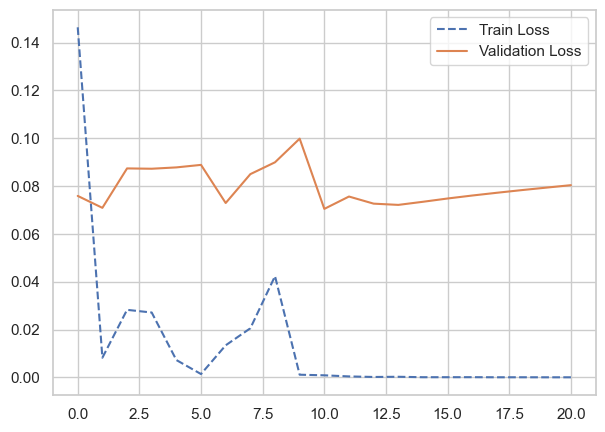

In [28]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [29]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load best trained model

In [ ]:
model_save_path = os.path.join(models_path, f"{model_name}_best_model.pth")
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

In [26]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.974     0.983     0.978       300
              Forest      0.990     1.000     0.995       300
HerbaceousVegetation      0.977     0.990     0.983       300
             Highway      0.965     0.992     0.978       250
          Industrial      1.000     0.992     0.996       250
             Pasture      0.980     0.970     0.975       200
       PermanentCrop      0.980     0.968     0.974       250
         Residential      1.000     0.997     0.998       300
               River      0.992     0.956     0.974       250
             SeaLake      1.000     1.000     1.000       300

            accuracy                          0.986      2700
           macro avg      0.986     0.985     0.985      2700
        weighted avg      0.986     0.986     0.986      2700



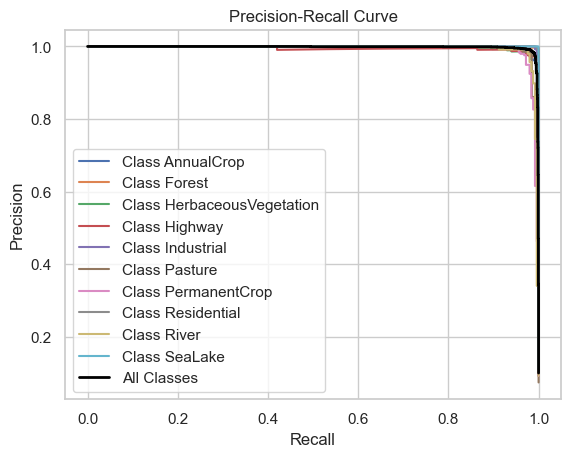

In [32]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [33]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▅▁▂▄▄▇▆▅▁█▇▇▇▇▇█████
val_loss,▂▁▅▅▅▅▂▄▆█▁▂▂▁▂▂▂▃▃▃▃
epoch,20
step,3100
train_loss,6e-05
val_accuracy,0.98333
val_loss,0.08038


In [27]:
del model2
torch.cuda.empty_cache()
gc.collect()

465